<a href="https://colab.research.google.com/github/federicochiarello/Hands-On-ML-Notebooks/blob/master/08_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# PCA

In [ ]:
# Build 3D dataset

m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## Principal Components

In [ ]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [ ]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [ ]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

## Projecting Down to d Dimensions

In [ ]:
W2 = Vt.T[:, :2]
X2D_using_svd = X2S = X_centered.dot(W2)

## Using Scikit-Learn

In [ ]:
from sklearn.decomposition import PCA

# Sklearn PCA takes care of mean centering by default
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [ ]:
X2D[:5]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852]])

In [ ]:
X2D_using_svd[:5]

array([[-0.690074  , -0.36150744],
       [ 1.39636097,  0.34497714],
       [ 1.00728461, -0.35025708],
       [ 0.2736333 , -0.50516373],
       [-0.91324535,  0.26290852]])

## Recover original points

In [ ]:
X3D_inv = pca.inverse_transform(X2D)
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

np.allclose(X3D_inv, X)

False

In [ ]:
# reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.009421417196957216

In [ ]:
# Reconstructions are identical (if we subtract the mean from Sklearn version)
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [ ]:
pca.components_

array([[-0.95250178, -0.24902446, -0.17529172],
       [ 0.29267159, -0.9076305 , -0.30091563]])

In [ ]:
Vt[:2]

array([[-0.95250178, -0.24902446, -0.17529172],
       [ 0.29267159, -0.9076305 , -0.30091563]])

## Explained Variance Ratio

In [ ]:
pca.explained_variance_ratio_

array([0.85406025, 0.13622918])

In [ ]:
1 - pca.explained_variance_ratio_.sum()

0.00971056761601341

## Choosing the right number of dimensions

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

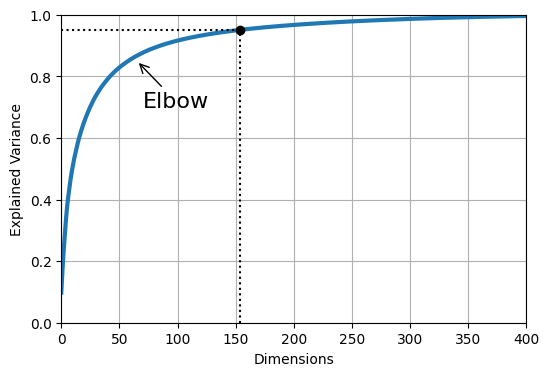

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

154

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9504506731634907

# PCA for Compression

In [ ]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

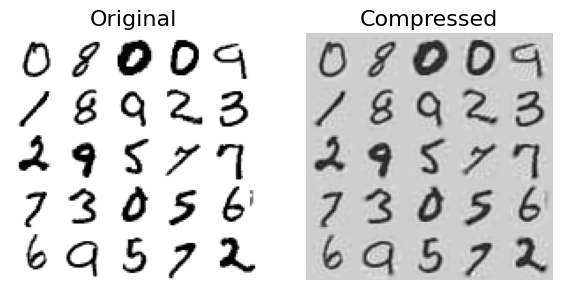

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

In [ ]:
X_reduced_pca = X_reduced

# Randomized PCA

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# Incremental PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced_inc_pca = inc_pca.transform(X_train)

In [ ]:
# results are close but not exactly identical
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

# Kernel PCA

In [ ]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced_kernel_pca = rbf_pca.fit_transform(X)

# LLE

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X)

# Other Dimensionality Reduction Techniques

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)